# Embeddings

In [1]:
from __future__ import print_function

In [2]:
import tensorflow as tf
import zipfile
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/home/aluno/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Tradicionalmente, aplicações relacionadas com linguagem natural tratam palavras como eventos discretos. Assim, duas palavras, como _cão_ e _gato_, são representados por identificadores arbitrários que não incorporam qualquer informação sobre as relações existentes entre esses conceitos como, por exemplo, que eles são animais mamíferos, com quatro patas, domesticáveis, etc. Outro problema deste tipo de codificação é que ela induz esparsidade, o que torna complexo o treinamento de um modelo estatístico.

Uma alternativa à representação esparsa arbitrária é a representação com vetores densos. Para obter tais vetores, podemos usar a Hipótese de Distribuição que estabelece que _palavras que aparecem no mesmo contexto, compartilham a mesma semântica_. Há dois tipos gerais de técnicas que se baseiam nessa hipótese: as baseadas em contagem, como a _Indexação Semântica Latente_, e as baseadas em previsão, como os _modelos de linguagem neuro-probabilísticos_. Nesta aula, nos concentramos nas últimas técnicas, que tentam prever diretamente uma palavra alvo apartir da suas vizinhas, aprendendo para isso pequenos vetores densos, que são parâmetros dos modelos. Estes vetores são chamados _embeddings_ de palavras (ou vetores de palavras, na falta de uma melhor tradução para o Português). 

Entre os vários métodos propostos nesta linha, um de grande destaque é o Word2vec (Mikolov et al., http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), onde redes neurais rasas e simples são usadas para aprender os embeddings. Com o uso de redes rasas, é possível escalar o modelo para lidar com trilhões de ocorrências de palavras.

Modelos de linguagem neuro-probabilísticos em geral são treinados de acordo com o princípio da máxima verossimelhança. Em particular, o modelo maximiza a probabilidade da próxima palavra, dada as palavras de contexto. Um modelo muito simples, baseado nesta ideia, é ilustrado a seguir.

Nele, há uma única camada escondida de $N$ neurônios. A entrada e a saída são conjuntos de $V$ neurônios, onde $V$ é o tamanho do vocabulário. Os neurônios de entrada representam uma palavra usando codificação _hot vector_. Nos neurônios de saída, a probabilidade de cada palavra é obtida via _softmax_. No exemplo a seguir, dada a frase _the cat_, a palavra _the_ representa a entrada (o contexto) que será usada para prever a palavra-alvo, _cat_.

<img src="images/emb0.png" alt="Exemplo de RNN" style="width: 400px;"/>

Note que como a entrada é 1-hot-vector, se a saída da camada oculta for linear, a saída dessa camada é meramente uma cópia dos pesos da entrada (${\bf h}_w = {\bf x}_w {\bf W}_{I} = {\bf W}_{Iw}$). Ou seja, o código usado para representar cada palavra (${\bf h}_w$) é o peso da entrada corresponde a esta palavra (${\bf W}_{Iw}$). E este será aprendido durante o treino. 

A estimativa da palavra alvo $w_t$ dado contexto é dada pela softmax, ou seja:

$$P(w_t|{\bf h}_w) = softmax(score(w_t, {\bf h}_w)) = \frac{e^{score(w_t, {\bf h}_w)}}{\sum_{w' \in \mathcal{V}}{e^{score(w', {\bf h}_w)}}}$$

onde $\mathcal{V}$ é o vocabulário e _score_ é normalmente o produto interno entre os vetores. Para calcular o erro, basta subtrair o vetor da palavra alvo do vetor de estimativa softmax. Com base no erro, os pesos são atualizados, de forma que a própria representação das palavras (${\bf h}_w$) é moficada para garantir que _palavras que normalmente ocorrem no mesmo contexto sejam capazes de prever umas às outras!_

Observe que o contexto, em geral, é formado por mais de uma palavra (e o alvo não precisa ser necessariamente a próxima). Para isso, basta representar cada palavra na entrada. Abaixo, por exemplo, temos uma arquitetura em que o contexto é formado por _m = 1_ palavras que ocorrem antes e depois da palavra alvo.

<img src="images/cbow.png" alt="Exemplo de RNN" style="width: 400px;"/>

Neste caso, dada a frase _the black cat_, o contexto é formado pelas palavras _the_ e _cat_ e o alvo é _black_. Note que uma camada de projeção aparece no desenho para indicar que as várias entradas discretas serão combinadas para formar uma entrada única: elas podem ser combinadas pela média, soma, multiplicação ou mesmo concatenação. 

Este modelo simples é chamado CBOW (_continuous bag-of-words_). Um modelo alternativo é o _Skip-gram_, que é basicamente a versão invertida do CBOW: ou seja, a entrada corresponde à palavra alvo e o alvo corresponde ao contexto. Embora a diferença entre os modelos pareça arbitrária, o skip-gram tem algumas vantagens em termos de amostragem estatística que o tornam uma solução melhor para o caso de grande número de ocorrência de palavras.

A seguir, vamos estudar esses modelos na prática.

### Obtendo dados

Vamos inicialmente obter palavras de uma amostra de 100Mb a Wikipedia em inglês de 2006.

In [4]:
def fetch_words_data():
    with zipfile.ZipFile('data/wiki2006_100m.zip') as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [5]:
words = fetch_words_data()

In [6]:
print(' '.join(words[:25]))

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes


In [8]:
len(words)

17005207

### Criando um dicionário

E criar um dicionário com estes dados.

In [9]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}

In [10]:
print(dictionary['UNK'], dictionary['anarchism'])

0 5234


In [11]:
# word code or 0, case word does not exist in dictionary
data = np.array([dictionary.get(word, 0) for word in words])

In [12]:
print(' '.join(words[:6]))
print(data[:6])
print(' '.join([vocabulary[i] for i in data[:6]]))

anarchism originated as a term of
[5234 3081   12    6  195    2]
anarchism originated as a term of


Note que o início do nosso texto é _anarchism originated as a term of_.

### Gerando batches

O modelo que vamos usar é o _skip-gram_. Neste modelo, supondo um contexto de duas palavras, para a sentença _anarchism originated as a term of_, teríamos os seguintes pares de contexto e alvo:

- ([anarchism, as], originated), ([originated, a], as),  ([as, term], a), ([a, of], term), ...

Como no modelo skip-gram nós usamos o alvo para prever o contexto, temos:

- (originated, anarchism), (originated, as), (as, originated), (as, a), (a, as), (a, term), (term, a), (term, of) ...

A seguir vamos definir uma função (generate_batch) que obtem exemplos para treinar um modelo _skip gram_. 

In [12]:
import random
from collections import deque

# num_skips = How many times to reuse an input to generate a label
# skip_window = How many words to consider left and right.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [13]:
data_index=0
batch, labels = generate_batch(8, 2, 1)
print (batch.shape)
print (labels.shape)

(8,)
(8, 1)


In [14]:
for i in range(len(batch)):
    print ('%d %10s -> %s' % (i, vocabulary[batch[i]], vocabulary[labels[:,0][i]]))

0 originated -> anarchism
1 originated -> as
2         as -> originated
3         as -> a
4          a -> term
5          a -> as
6       term -> of
7       term -> a


### Skip-gram

In [16]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [17]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

Note que maximizar o $\log P(w_t|{\bf h}_w)$ corresponde a maximizar a função de custo:

$$J = \log \frac{e^{score(w_t, {\bf h}_w)}}{\sum_{w' \in \mathcal{V}}{e^{score(w', {\bf h}_w)}}} = score(w_t, {\bf h}_w) - \log{\sum_{w' \in \mathcal{V}}{e^{score(w', {\bf h}_w)}}}$$

Enquanto $J$ corresponde a uma estimativa adequada de um ponto de vista probabilístico, ela é muito cara para ser processada para cada instância de treino, uma vez que o somatório é marginalizado sobre todas as palavras do vocabulário ($w' \in \mathcal{V}$).

Assim, em lugar de calcular um modelo probabilístico completo, nosso objetivo no treino será o de uma regressão logística binária. Em particular, para nosso modelo skip-gram, queremos discriminar quem é o melhor previsor para as palavras de contexto ${\bf h}$: o alvo $w_t$ ou $k$ palavras tomadas aleatoriamente (ruído ${\bf \tilde{w}}$)?

Formalmente, nosso objetivo passa a ser maximizar:

$$J_{NEG} = \log Q_{\theta}(D=1 | w_t, {\bf h}) + k \mathop{\mathbb{E}}_{{\bf \tilde{w}} \approx P_{noise}}[\log ⁡Q_{\theta} (D=0 | {\bf \tilde{w}}, {\bf h})]$$

onde $\log Q_{\theta}(D=1 | w_t, {\bf h})$ é a probabilidade (obtida com um regressor logístico binário) de $w_t$ ser vista no contexto ${\bf h}$ para um conjunto de dados $D$, considerando um conjunto de embeddings $\theta$. O segundo componente da equação corresponde à probabilidade de que $k$ palavras contrastivas ${\bf \tilde{w}}$ (tomadas aleatorimente de $\mathcal{V}$) _não_ sejam vistas no contexto ${\bf h}$. Por exemplo, digamos que temos a frase _the black cat_, com contexto dado por (_the_, _cat_) e alvo dado por _cat_. Em $J_{NEG}$ pretende-se maximizar a probabilidade de _black_ ser vista no contexto (_the_, _cat_) ao mesmo tempo que se minimiza a probabilidade de que $k$ palavras tomadas aleatoriamente, como (_then_, _observe_, _those_) para $k=3$, sejam vistas no mesmo contexto. A figura abaixo ilustra essa estratégia em um modelo skip-gram:

<img src="images/skip-gram-neg-sampling.png" alt="Relações em embeddings" style="width: 500px;"/>

Em suma, o objetivo é máximizado quando o modelo associa probabilidades altas para palavras que fazem sentido no contexto (_black_) e baixa para palavras ruído (_then_, _observe_, _those_). Esta estratégia é chamada _Negative Sampling_ e há duas boas razões para usá-la: (1) as atualizações que ela propões aproximam as atualizações da softmax no limite; e (2) o custo por instância de treino do estimador cai de $O(\mathcal{V})$ para $O(k)$, $k << \mathcal{V}$. O tensorflow oferece um estimador baseado nesta ideia, o _noise-contrastive estimation (NCE) loss_ -- `tf.nn.nce_loss()`.

In [18]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [19]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [20]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Treinamento

In [21]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Avg loss at ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 5 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "- %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

ResourceExhaustedError: OOM when allocating tensor of shape [50000,150] and type float
	 [[Node: Variable/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [50000,150] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'Variable/Adam/Initializer/zeros', defined at:
  File "/home/aluno/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aluno/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/aluno/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/aluno/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/aluno/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-0866361807e0>", line 16, in <module>
    training_op = optimizer.minimize(loss)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 409, in minimize
    name=name)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 585, in apply_gradients
    self._create_slots(var_list)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 127, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 1130, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 181, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 155, in create_slot_with_initializer
    dtype)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1328, in get_variable
    constraint=constraint)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1090, in get_variable
    constraint=constraint)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 435, in get_variable
    constraint=constraint)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 404, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 796, in _get_single_variable
    use_resource=use_resource)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2234, in variable
    use_resource=use_resource)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2224, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2207, in default_variable_creator
    constraint=constraint)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 368, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 780, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py", line 99, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1550, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2793, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/aluno/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [50000,150] and type float
	 [[Node: Variable/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [50000,150] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [21]:
np.save("/tmp/my_final_embeddings.npy", final_embeddings)

In [22]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

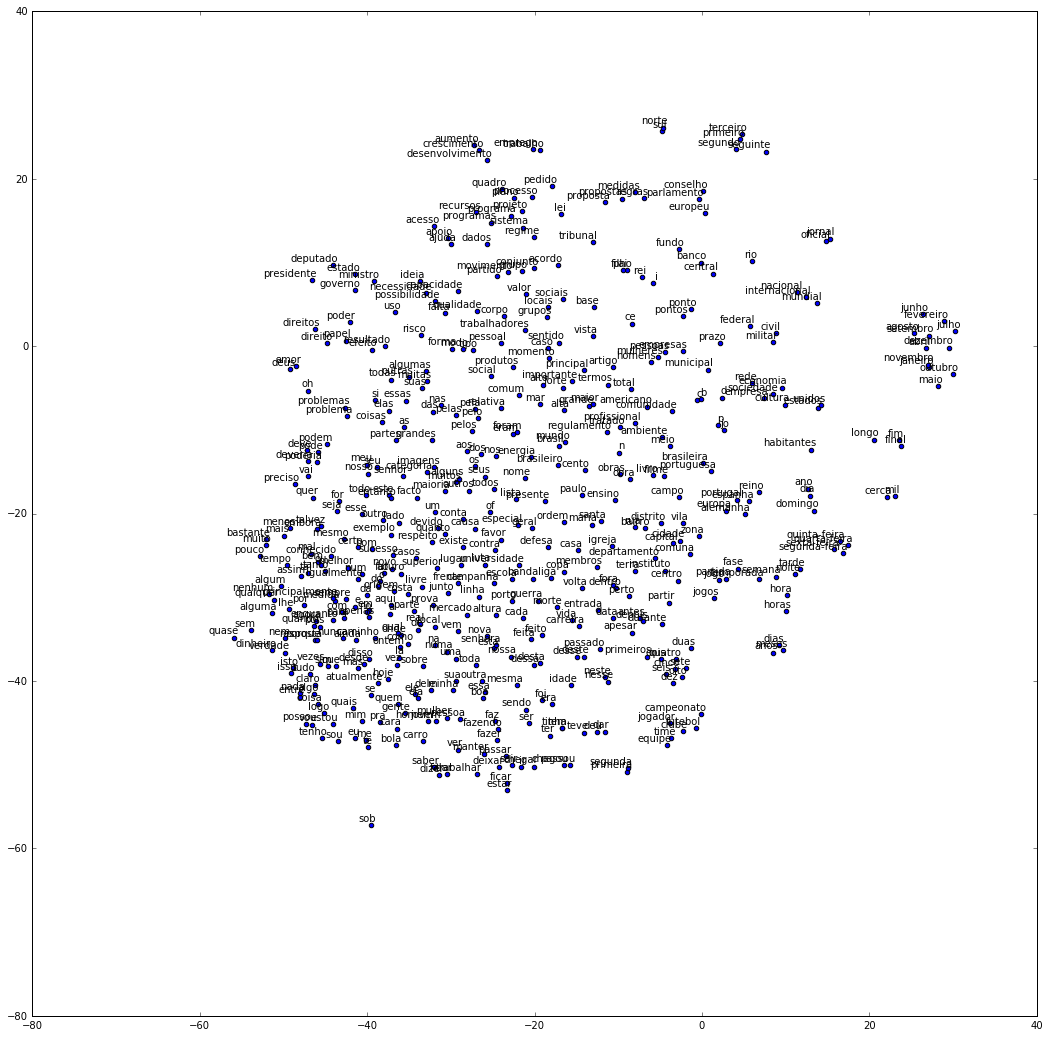

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

Como treinamos pouco nossos embeddings, muitas das suas propriedades não estão ainda observáveis. Contudo, ao analisar um conjunto de embeddings bem treinado, é fácil perceber que os embeddings capturam informação semântica geral e bastante útil. De fato, o uso de embeddings melhora o desempenho de várias atividades envolvendo linguagem natural, tais como agrupamento, classificação, reconhecimento de tipos de discurso, etc.

### Usando _embeddings_ Pré-treinados (com Gensim)

Especializações comumente observadas nos eixos dos embeddings incluem relacionamentos semânticos como o de gênero (feminino v. masculino), conjugações verbais, relações geográficas, etc. Algumas destas são demonstradas nas figuras abaixo:

<img src="images/linear-relationships.png" alt="Relações em embeddings" style="width: 600px;"/>

Podemos observar tais especializações em conjuntos pré-treinados de embeddings. Há vários destes conjuntos disponíveis:

* Inglês: https://github.com/alexandres/lexvec#pre-trained-vectors
* Inlgês (Glove): https://nlp.stanford.edu/projects/glove/
* Português: http://www.nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

Nos exemplos a seguir, usamos um conjunto de embeddings para língua portuguesa, obtidos do NILC, treinados com skip-gram. Dos 2.6 Gbytes de dados da coleção original, separamos cerca de 24 mil embeddings, usando uma lista de palavras da língua portuguesa.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def load_embeddings(fname):
    vocab = []
    embd = []
    file = open(fname,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        if len(row) > 2:
            vocab.append(row[0])
            embd.append(row[1:])
    print('done: %d %d-D embeddings loaded!' % (len(vocab), len(embd[0])))
    file.close()
    return vocab, embd

In [26]:
fname = 'data/subset_skip_s300.txt'
vocabulary, embd = load_embeddings(fname)
vocab_size = len(vocabulary)
embedding_dim = len(embd[0])
final_embeddings = np.asarray(embd)

done: 24339 300-D embeddings loaded!


In [27]:
final_embeddings.shape

(24339, 300)

A seguir, plotamos algumas palavras no espaço de embeddings, usando PCA.

In [28]:
vdic = {vocabulary[i]:i for i in range(vocab_size)}
labels = ['futebol', 'handebol', 'voleibol', 'basquetebol', 'golfe', 
          'nadar', 'correr', 'chutar', 'pular', 'ver', 
          'tigre', 'leao', 'macaco', 'morcego', 'golfinho']
ids = np.array([vdic[w] for w in labels])

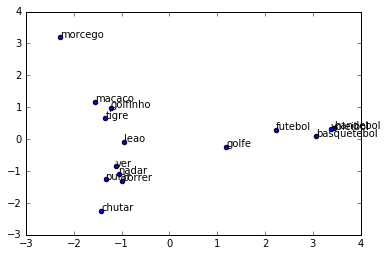

In [29]:
from sklearn.decomposition import PCA
# fit a 2d PCA model to the vectors
X = final_embeddings[ids]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(labels)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Note como cada classe de palavras ficou separada no espaço, de forma coerente de acordo com os conceitos que elas denotam. A seguir, temos exemplos de artimética com embeddings, usando o pacote _gensim_.

In [30]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(fname)

In [31]:
model.most_similar('homem', topn=5)

[(u'rapaz', 0.6592525839805603),
 (u'garoto', 0.6111440658569336),
 (u'idoso', 0.5899262428283691),
 (u'bandido', 0.548312783241272),
 (u'forasteiro', 0.542189359664917)]

In [32]:
model.most_similar(positive=['homem', 'jovem'], topn=5)

[(u'rapaz', 0.7089483737945557),
 (u'garoto', 0.6976317763328552),
 (u'idoso', 0.6626265048980713),
 (u'adolescente', 0.6502277851104736),
 (u'menino', 0.6060273051261902)]

In [33]:
model.most_similar(negative=['chuva'], topn=5)

[(u'integrado', 0.1639753133058548),
 (u'desvincular', 0.16268056631088257),
 (u'planejador', 0.16177934408187866),
 (u'criacionismo', 0.1557948738336563),
 (u'unico', 0.1523056924343109)]

In [34]:
# mulher + rei - homem
result = model.most_similar(positive=['mulher', 'rei'], negative=['homem'], topn=1)
print(result)

[(u'rainha', 0.6600958108901978)]


In [35]:
result = model.most_similar(positive=['amigo', 'dinheiro'], topn=1)
print(result)

[(u'pai', 0.5456974506378174)]


In [36]:
result = model.most_similar(positive=['homem'], negative=['dinheiro'], topn=1)
print(result)

[(u'sonhador', 0.3776102662086487)]


In [37]:
result = model.most_similar(positive=['mulher'], negative=['dinheiro'], topn=1)
print(result)

[(u'menina', 0.5010708570480347)]


In [38]:
result = model.most_similar(positive=['menina', 'casamento'], topn=1)
print(result)

[(u'mulher', 0.6413488984107971)]


O material desta aula se baseou no tutorial de Word2vec do tensorflow (https://www.tensorflow.org/tutorials/word2vec) e no livro de Aurélien Géron, "Hands-on Machine Learning with Skitlearn and Tensorflow".